In [12]:
!pip install sodapy
!pip install ace_tools
!pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 14.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 13.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
from sodapy import Socrata

# Connect to the data.ny.gov API
client = Socrata("data.ny.gov", None)

# Fetch a sample of the data to inspect the columns
sample_results = client.get("wujg-7c2s", limit=5)

# Convert to pandas DataFrame
sample_df = pd.DataFrame.from_records(sample_results)

# Print the available columns
print("Available Columns:")
print(sample_df.columns)


Available Columns:
Index(['transit_timestamp', 'transit_mode', 'station_complex_id',
       'station_complex', 'borough', 'payment_method', 'fare_class_category',
       'ridership', 'transfers', 'latitude', 'longitude', 'georeference',
       ':@computed_region_kjdx_g34t', ':@computed_region_yamh_8v7k',
       ':@computed_region_wbg7_3whc'],
      dtype='object')


In [4]:
import pandas as pd
from sodapy import Socrata
from datetime import datetime, timedelta
import os

# Connect to the data.ny.gov API
client = Socrata("data.ny.gov", None)

# Define the start and end times for May 17, 2024
start_time = "2024-05-17T00:00:00.000"
end_time = "2024-05-17T23:59:59.999"

# Fetch all data for May 17, 2024
results = client.get(
    "wujg-7c2s",
    where=f"transit_timestamp >= '{start_time}' AND transit_timestamp <= '{end_time}'",
    limit=50000  # Set a higher limit to capture all records
)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

# Generate timestamps for every second of the day
start_time_dt = datetime(2024, 5, 17, 0, 0, 0)
timestamps = [start_time_dt + timedelta(seconds=i) for i in range(86400)]

# Create a DataFrame with all timestamps
timestamps_df = pd.DataFrame(timestamps, columns=["transit_timestamp"])
timestamps_df["transit_timestamp"] = timestamps_df["transit_timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%S.000")

# Merge the generated timestamps with actual data
merged_df = pd.merge(timestamps_df, results_df, on="transit_timestamp", how="left")

# Save the complete data to CSV
os.makedirs("./data", exist_ok=True)
file_path = "./data/may_17_2024_full_day.csv"
merged_df.to_csv(file_path, index=False)

file_path


'./data/may_17_2024_full_day.csv'

In [9]:
import pandas as pd
from datetime import datetime, timedelta

# Load the existing data
file_path = './data/may_17_2024_full_day.csv'
data_df = pd.read_csv(file_path, low_memory=False)

# Generate all possible timestamps for May 17, 2024
start_time = datetime(2024, 5, 17, 0, 0, 0)
end_time = datetime(2024, 5, 17, 23, 59, 59)
all_timestamps = pd.DataFrame(
    [start_time + timedelta(seconds=i) for i in range(86400)],
    columns=["transit_timestamp"]
)
all_timestamps["transit_timestamp"] = all_timestamps["transit_timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%S.000")

# Merge with the original data to fill missing timestamps
complete_df = pd.merge(all_timestamps, data_df, on="transit_timestamp", how="left")

# Fill missing values with defaults
complete_df.fillna({
    "transit_mode": "unknown",
    "station_complex_id": -1,
    "station_complex": "unknown",
    "borough": "unknown",
    "payment_method": "unknown",
    "fare_class_category": "unknown",
    "ridership": 0,
    "transfers": 0,
    "latitude": 0.0,
    "longitude": 0.0,
    "georeference": "{}"
}, inplace=True)

# Save the filled data to a new CSV
output_file = "./data/may_17_2024_full_day_filled.csv"
complete_df.to_csv(output_file, index=False)

# Basic Analysis
summary = {
    "Total Data Points": len(complete_df),
    "Total Unique Stations": complete_df["station_complex"].nunique(),
    "Total Ridership": complete_df["ridership"].sum(),
    "Average Ridership per Station (Top 10)": complete_df.groupby("station_complex")["ridership"].mean().sort_values(ascending=False).head(10),
    "Peak Hour (Top 5)": complete_df.groupby(complete_df["transit_timestamp"].str[:13])["ridership"].sum().sort_values(ascending=False).head(5),
    "Top 5 Stations": complete_df.groupby("station_complex")["ridership"].sum().sort_values(ascending=False).head(5),
}

# Print the summary and a sample of the filled data
print("Summary of the Data:")
print(summary)

print("\nSample of the Filled Data:")
print(complete_df.head(10))


Summary of the Data:
{'Total Data Points': 136383, 'Total Unique Stations': 429, 'Total Ridership': np.float64(2290220.0), 'Average Ridership per Station (Top 10)': station_complex
Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)      503.601399
Grand Central-42 St (S,4,5,6,7)                       350.468966
34 St-Herald Sq (B,D,F,M,N,Q,R,W)                     252.355072
74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,M,R)    241.267606
34 St-Penn Station (A,C,E)                            226.321168
Flushing-Main St (7)                                  220.335570
Fulton St (A,C,J,Z,2,3,4,5)                           213.007463
14 St-Union Sq (L,N,Q,R,W,4,5,6)                      211.364865
34 St-Penn Station (1,2,3)                            195.084507
59 St-Columbus Circle (A,B,C,D,1)                     175.150376
Name: ridership, dtype: float64, 'Peak Hour (Top 5)': transit_timestamp
2024-05-17T15    295081.0
2024-05-17T08    288390.0
2024-05-17T07    271799.0
2024-05-17T14    24

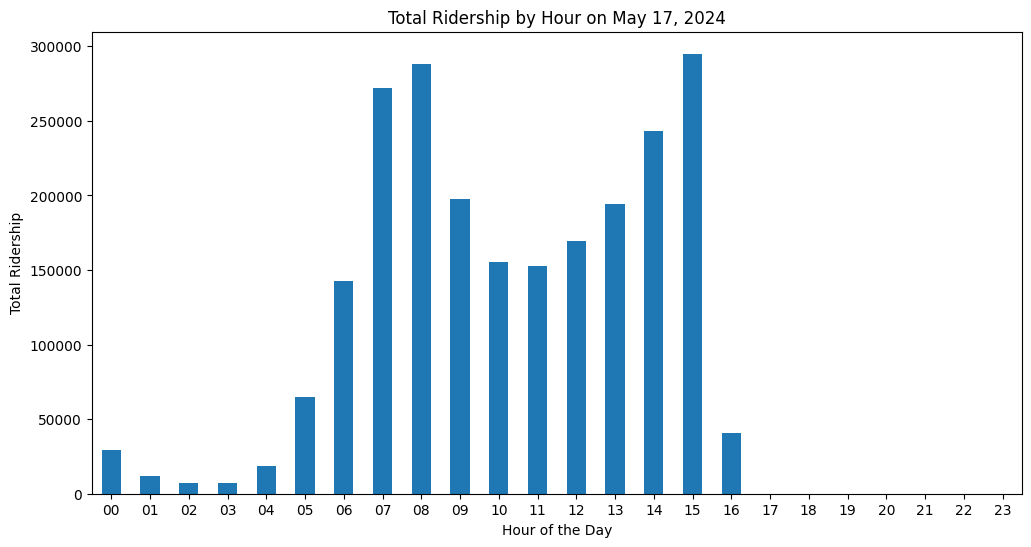

In [13]:
import matplotlib.pyplot as plt

# Extract hour from the timestamp for grouping
complete_df["hour"] = complete_df["transit_timestamp"].str[11:13]

# Group by hour and sum ridership
hourly_ridership = complete_df.groupby("hour")["ridership"].sum()

# Plot hourly ridership
plt.figure(figsize=(12, 6))
hourly_ridership.plot(kind="bar")
plt.title("Total Ridership by Hour on May 17, 2024")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Ridership")
plt.xticks(rotation=0)
plt.show()


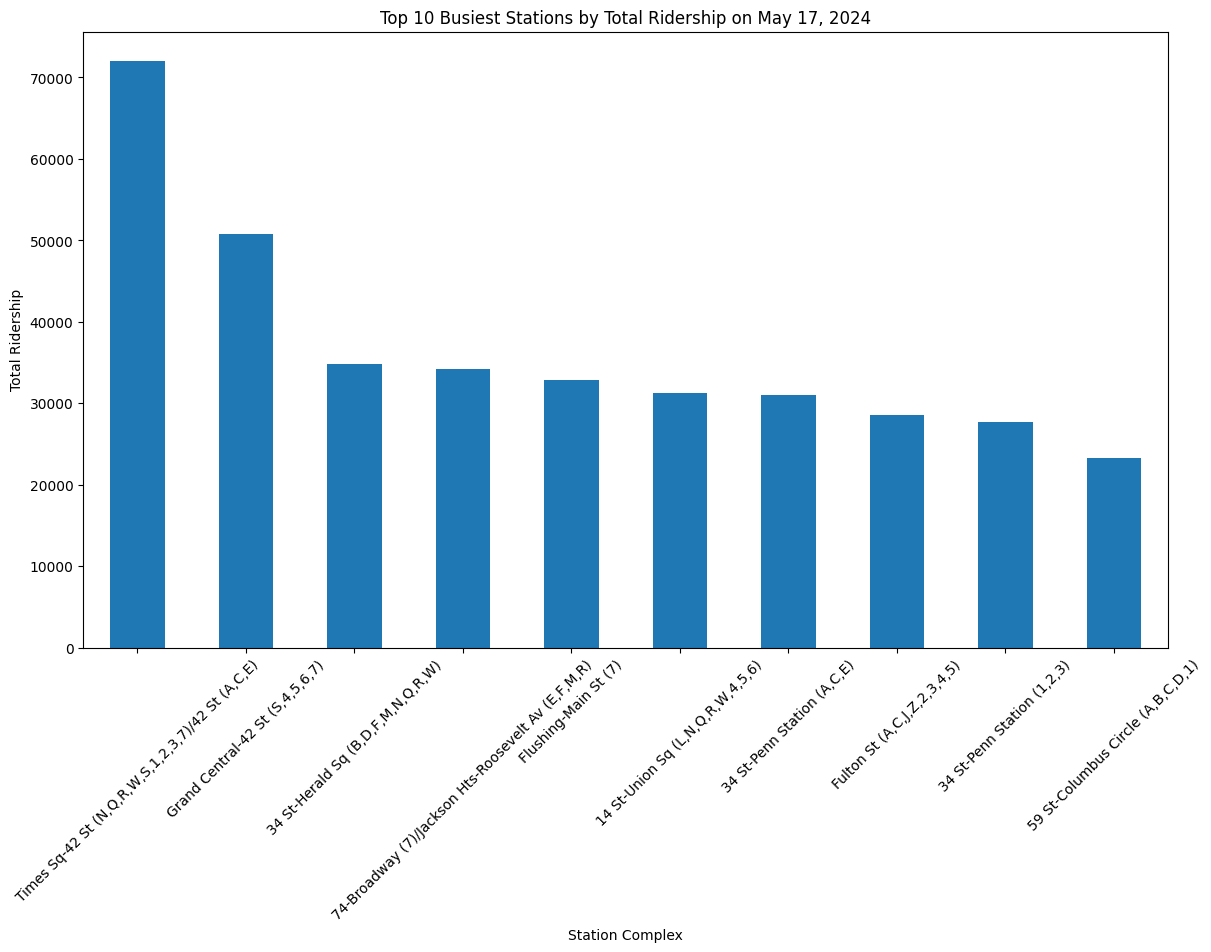

In [14]:
# Group by station and sum ridership
station_ridership = complete_df.groupby("station_complex")["ridership"].sum().sort_values(ascending=False).head(10)

# Plot the top 10 busiest stations
plt.figure(figsize=(14, 8))
station_ridership.plot(kind="bar")
plt.title("Top 10 Busiest Stations by Total Ridership on May 17, 2024")
plt.xlabel("Station Complex")
plt.ylabel("Total Ridership")
plt.xticks(rotation=45)
plt.show()


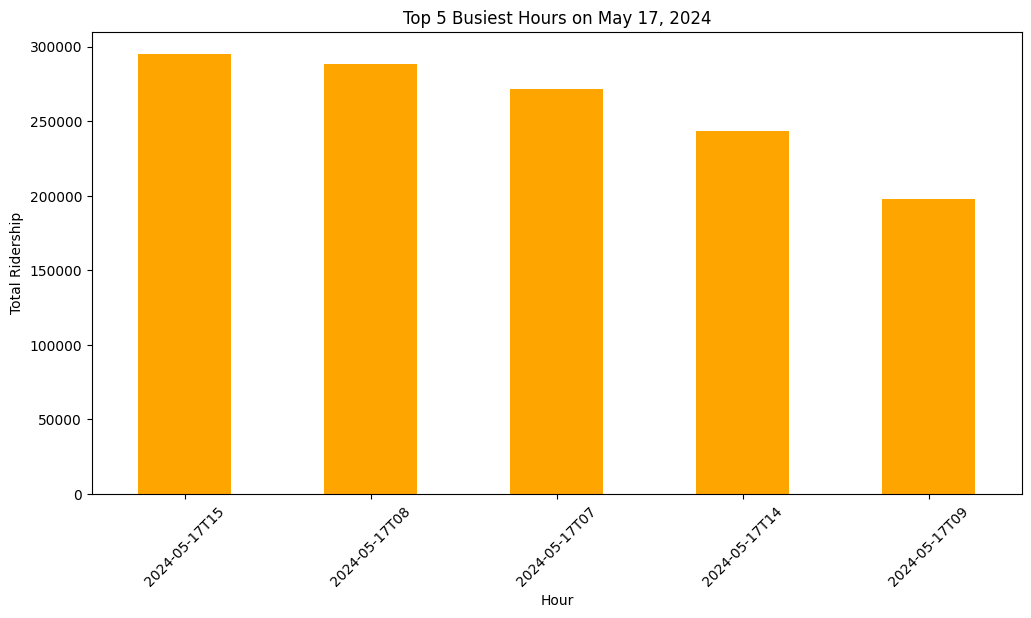

In [15]:
# Group by full hour and sum ridership
hourly_peak = complete_df.groupby(complete_df["transit_timestamp"].str[:13])["ridership"].sum().sort_values(ascending=False).head(5)

# Plot the peak hours
plt.figure(figsize=(12, 6))
hourly_peak.plot(kind="bar", color="orange")
plt.title("Top 5 Busiest Hours on May 17, 2024")
plt.xlabel("Hour")
plt.ylabel("Total Ridership")
plt.xticks(rotation=45)
plt.show()
